In [ ]:
!pip install rna-fm
!pip install lime
!pip install torch

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


In [1]:
import pandas as pd
df = pd.read_csv('cas_augmented_balanced_data.csv')
df.head()

,target,sequence,design,cas_avg,kd_avg,activity
0,A,TggCaagcatcCTgtA,LDDLDDDDDDDLLDDL,313.665050,47.781193,1
1,A,TggCAagcUtcCTGTA,LDDLLDDDDDDLLLLL,365.989835,61.182137,1
2,B,ACTgccttctTUC,LLLDDDDDDDLDL,383.029282,51.661337,1
3,A,GGcaagcatccTG,LLDDDDDDDDDLL,553.610826,52.965501,1
4,B,GGtActgccttCTTaC,LLDLDDDDDDDLLLDL,306.875277,48.517747,1


In [ ]:
activity_counts = df['activity'].value_counts()
print(activity_counts)

activity
1    1653
0    1653
Name: count, dtype: int64


In [ ]:
import torch
print(torch.cuda.is_available())

True


In [ ]:
import pandas as pd
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, matthews_corrcoef,
                             cohen_kappa_score)
import numpy as np
import fm

# -- 1. Read data:
label_map = {lab: idx for idx, lab in enumerate(df['activity'].unique())}
df['label'] = df['activity'].map(label_map)

# -- 2. RNA-FM loading:
import fm
model_fm, alphabet = fm.pretrained.rna_fm_t12()
batch_converter = alphabet.get_batch_converter()
model_fm.eval()

BioBertModel(
  (embed_tokens): Embedding(25, 640, padding_idx=1)
  (layers): ModuleList(
    (0-11): 12 x TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=640, out_features=640, bias=True)
        (v_proj): Linear(in_features=640, out_features=640, bias=True)
        (q_proj): Linear(in_features=640, out_features=640, bias=True)
        (out_proj): Linear(in_features=640, out_features=640, bias=True)
      )
      (self_attn_layer_norm): LayerNorm((640,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=640, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=640, bias=True)
      (final_layer_norm): LayerNorm((640,), eps=1e-05, elementwise_affine=True)
    )
  )
  (contact_head): ContactPredictionHead(
    (regression): Linear(in_features=240, out_features=1, bias=True)
    (activation): Sigmoid()
  )
  (embed_positions): LearnedPositionalEmbedding(1026, 640, padding_idx=1)
  (emb_layer_norm_

In [ ]:
# Function to get per-seq embedding for a batch of RNAs:
@torch.no_grad()
def rna_fm_embed(seqs_batch):
    batch_labels, batch_strs, batch_tokens = batch_converter([(None, seq) for seq in seqs_batch])
    out = model_fm(batch_tokens, repr_layers=[12])
    emb = out["representations"][12]  # (batch, L, D)
    # global semantic = mean pooling over tokens
    sem = emb.mean(dim=1)  # (batch, D)
    return emb, sem

# -- 3. Custom Dataset
class RNASeqDataset(Dataset):
    def __init__(self, df):
        self.seqs = df['sequence'].tolist()
        self.labels = df['label'].values
    def __len__(self):
        return len(self.seqs)
    def __getitem__(self, idx):
        seq = self.seqs[idx]
        lbl = self.labels[idx]
        return seq, lbl

# Split dataset
ds = RNASeqDataset(df)
train_len = int(0.8*len(ds))
val_len = len(ds) - train_len
ds_train, ds_val = random_split(ds, [train_len, val_len])
train_loader = DataLoader(ds_train, batch_size=16, shuffle=True, collate_fn=lambda b: b)
val_loader = DataLoader(ds_val, batch_size=16, shuffle=False, collate_fn=lambda b: b)

# -- 4. Model: TCN + Adaptive Fusion + Stacked LSTM + Classifier
# One-hot nucleotide encoder
def one_hot_encode(seqs, max_len=512):
    mapping = {'A': 0, 'C': 1, 'G': 2, 'U': 3, 'T': 4, 'a': 5, 'c': 6, 'g': 7, 'u': 8, 't': 9}
    # Determine the maximum sequence length in the current batch if not using a fixed max_len
    current_max_len = max(len(seq) for seq in seqs)
    max_len = min(max_len, current_max_len) # Use the smaller of the two
    one_hot = torch.zeros(len(seqs), max_len, 10)
    for i, seq in enumerate(seqs):
        for j, nt in enumerate(seq[:max_len]):
            if nt in mapping:
                one_hot[i, j, mapping[nt]] = 1
    return one_hot


# Attention-based token pooling
class TokenAttention(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.att = nn.Linear(input_dim, 1)

    def forward(self, x):
        scores = self.att(x)  # (B, L, 1)
        weights = torch.softmax(scores, dim=1)
        pooled = (x * weights).sum(dim=1)
        return pooled

# Updated TCN block with smaller kernel and tighter dilation
class TCNBlock(nn.Module):
    def __init__(self, c_in, c_out, kernel_size, dilation):
        super().__init__()
        padding = (kernel_size - 1) * dilation
        self.conv1 = nn.Conv1d(c_in, c_out, kernel_size, padding=padding, dilation=dilation)
        self.conv2 = nn.Conv1d(c_out, c_out, kernel_size, padding=padding, dilation=dilation)
        self.relu = nn.ReLU()
        self.downsample = nn.Conv1d(c_in, c_out, 1) if c_in != c_out else nn.Identity()

    def forward(self, x):
        res = self.downsample(x)
        out = self.relu(self.conv1(x))
        out = self.conv2(out)
        return self.relu(out[:, :, :res.shape[-1]] + res)

# Full TCN
class TCN(nn.Module):
    def __init__(self, input_size, channels, kernel_size=2):
        super().__init__()
        layers = []
        for i, out_ch in enumerate(channels):
            in_ch = input_size if i == 0 else channels[i-1]
            dilation = 2 ** i
            layers.append(TCNBlock(in_ch, out_ch, kernel_size=kernel_size, dilation=dilation))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

# Final classifier model
class Classifier(nn.Module):
    def __init__(self, fm_dim=640, tcn_channels=[128, 128, 128, 128], lstm_layers=4, lstm_hid=128, num_classes=2, dropout=0.3):
        super().__init__()
        # Corrected input_size for TCN to match one-hot encoding output (10 channels)
        self.tcn = TCN(input_size=10, channels=tcn_channels)
        self.fm_token_proj = nn.Linear(fm_dim, fm_dim)
        self.token_attention = TokenAttention(fm_dim)
        self.att_fusion = nn.Linear(fm_dim + tcn_channels[-1], fm_dim)
        self.lstm = nn.LSTM(input_size=fm_dim, hidden_size=lstm_hid, num_layers=lstm_layers,
                            batch_first=True, dropout=dropout)
        self.classifier = nn.Sequential(
            nn.Linear(lstm_hid, lstm_hid//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(lstm_hid//2, num_classes)
        )

    def forward(self, emb_tokens, sem_emb, onehot):
        # onehot: (B, L, 10) --> (B, 10, L)
        tcn_out = self.tcn(onehot.transpose(1, 2)).transpose(1, 2)  # (B, L, C)
        fm_tokens_proj = self.fm_token_proj(emb_tokens)  # project FM to same space
        sem_attn = self.token_attention(fm_tokens_proj)  # learnable pooling (B, D)
        sem = sem_emb + sem_attn  # combine global semantic and attention-pooled

        sem = sem.unsqueeze(1).expand(-1, tcn_out.size(1), -1)
        fused = torch.cat((sem, tcn_out), dim=-1)
        fused = torch.tanh(self.att_fusion(fused))
        out, _ = self.lstm(fused)
        pooled = out[:, -1, :]
        return self.classifier(pooled)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Classifier(num_classes=len(label_map)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# -- 5. Train + Val loops
def epoch_loop(loader, train=True):
    total_loss, preds, reals = 0, [], []
    for batch in loader:
        seqs, labs = zip(*batch)
        emb_tokens, sem = rna_fm_embed(seqs)
        # Get the maximum sequence length in the current batch
        max_len_batch = max(len(seq) for seq in seqs)
        emb_tokens, sem = emb_tokens.to(device), sem.to(device)
        # Pass the determined max_len_batch to one_hot_encode
        onehot = one_hot_encode(seqs, max_len=max_len_batch).to(device)
        labs = torch.tensor(labs, device=device)

        if train:
           model.train()
           optimizer.zero_grad()
           logits = model(emb_tokens, sem, onehot)
           loss = criterion(logits, labs)
           loss.backward()
           optimizer.step()
        else:
           model.eval()
           with torch.no_grad():
                logits = model(emb_tokens, sem, onehot)
                loss = criterion(logits, labs)

        total_loss += loss.item() * labs.size(0)
        y_hat = logits.argmax(dim=1).cpu().numpy()
        preds.extend(y_hat)
        reals.extend(labs.cpu().numpy())

    avg_loss = total_loss / len(loader.dataset)
    acc = accuracy_score(reals, preds)
    precision = precision_score(reals, preds, average='weighted', zero_division=0)
    recall = recall_score(reals, preds, average='weighted', zero_division=0)
    f1 = f1_score(reals, preds, average='weighted', zero_division=0)
    mcc = matthews_corrcoef(reals, preds)
    kappa = cohen_kappa_score(reals, preds)
    cm = confusion_matrix(reals, preds)
    return avg_loss, acc, precision, recall, f1, mcc, kappa, cm

# -- 6. Training main
num_epochs = 15
hist = {'tr_loss':[], 'val_loss':[], 'tr_acc':[], 'val_acc':[]}

for e in range(1, num_epochs+1):
    tr = epoch_loop(train_loader, train=True)
    val = epoch_loop(val_loader, train=False)
    hist['tr_loss'].append(tr[0]); hist['val_loss'].append(val[0])
    hist['tr_acc'].append(tr[1]); hist['val_acc'].append(val[1])
    print(f"Epoch {e}: Train loss {tr[0]:.4f}, Val loss {val[0]:.4f}, Acc {tr[1]:.4f}/{val[1]:.4f}")

Epoch 1: Train loss 0.6688, Val loss 0.6369, Acc 0.5847/0.6284
Epoch 2: Train loss 0.5167, Val loss 0.4375, Acc 0.7530/0.8127
Epoch 3: Train loss 0.4119, Val loss 0.3684, Acc 0.8196/0.8535
Epoch 4: Train loss 0.3615, Val loss 0.3749, Acc 0.8480/0.8505
Epoch 5: Train loss 0.3376, Val loss 0.3237, Acc 0.8548/0.8580
Epoch 6: Train loss 0.3043, Val loss 0.2819, Acc 0.8759/0.8701
Epoch 7: Train loss 0.2786, Val loss 0.2844, Acc 0.8839/0.8610
Epoch 8: Train loss 0.2654, Val loss 0.3466, Acc 0.8877/0.8444
Epoch 9: Train loss 0.2650, Val loss 0.3108, Acc 0.8911/0.8671
Epoch 10: Train loss 0.2434, Val loss 0.2425, Acc 0.8926/0.8852
Epoch 11: Train loss 0.2414, Val loss 0.2404, Acc 0.8960/0.8912
Epoch 12: Train loss 0.2476, Val loss 0.2507, Acc 0.8911/0.8927
Epoch 13: Train loss 0.2252, Val loss 0.2404, Acc 0.9096/0.8912
Epoch 14: Train loss 0.2231, Val loss 0.2611, Acc 0.9032/0.8927
Epoch 15: Train loss 0.2232, Val loss 0.2404, Acc 0.9032/0.8897


In [ ]:
# Save the trained model
torch.save(model.state_dict(), 'caspase_rna_classifier.pth')

In [ ]:
# To open the trained model, you would load the state dictionary back into a model instance
# First, instantiate a new model with the same architecture
loaded_model = Classifier()

# Then, load the saved state dictionary
loaded_model.load_state_dict(torch.load('caspase_rna_classifier.pth'))

# Set the model to evaluation mode
loaded_model.eval()

print("Model loaded successfully!")

Model loaded successfully!


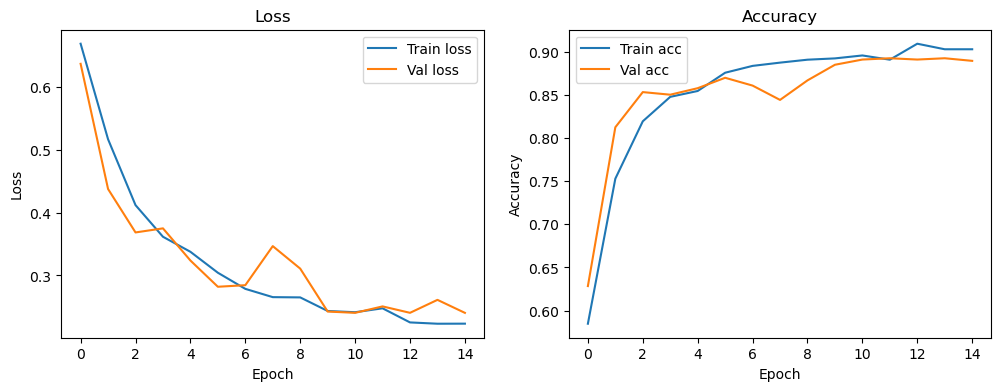

In [ ]:
# -- 7. Plotting
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(hist['tr_loss'], label='Train loss')
plt.plot(hist['val_loss'], label='Val loss')
plt.legend(); plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(hist['tr_acc'], label='Train acc')
plt.plot(hist['val_acc'], label='Val acc')
plt.legend(); plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
# Calculate metrics for the final report
trm = epoch_loop(train_loader, train=False)
vm = epoch_loop(val_loader, train=False)

# Create DataFrames for metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'MCC', 'Cohen\'s Kappa']
train_metrics_df = pd.DataFrame([trm[1:-1]], columns=metrics, index=['Train'])
val_metrics_df = pd.DataFrame([vm[1:-1]], columns=metrics, index=['Validation'])

print("Final Metrics:")
combined_metrics_df = pd.concat([train_metrics_df, val_metrics_df])
combined_metrics_df

Final Metrics:


,Accuracy,Precision,Recall,F1 Score,MCC,Cohen's Kappa
Train,0.922466,0.922498,0.922466,0.922466,0.844964,0.844935
Validation,0.889728,0.889745,0.889728,0.889718,0.779408,0.779376


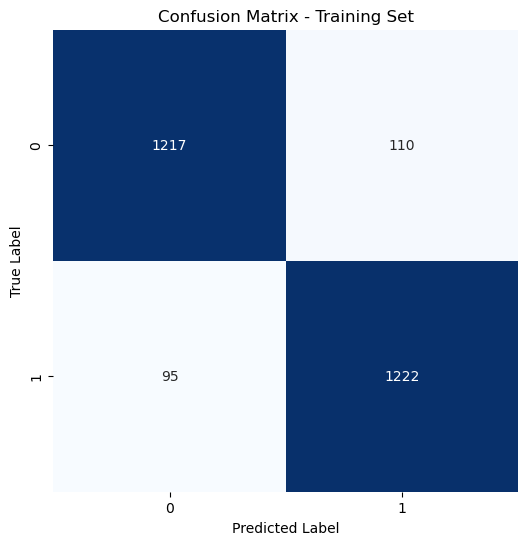

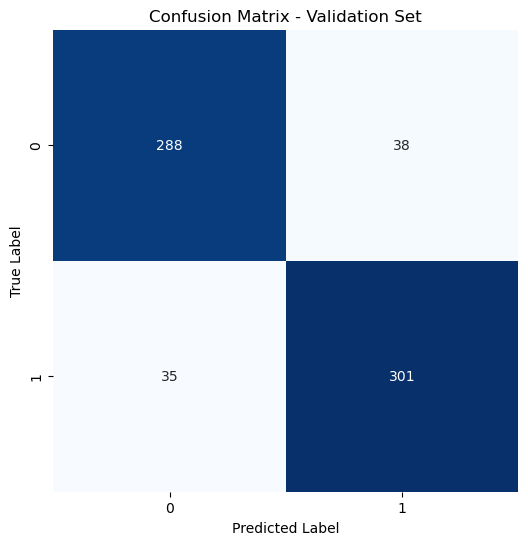

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, data_loader, title, device):
    all_preds, all_labels = [], []
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for batch in data_loader:
            seqs, labels = zip(*batch)
            emb_tokens, sem = rna_fm_embed(seqs)
            # Get the maximum sequence length in the current batch
            max_len_batch = max(len(seq) for seq in seqs)
            emb_tokens, sem = emb_tokens.to(device), sem.to(device)
            # Generate one-hot encoded sequences
            onehot = one_hot_encode(seqs, max_len=max_len_batch).to(device)
            labels = torch.tensor(labels, device=device)

            # Pass onehot to the model
            outputs = model(emb_tokens, sem, onehot)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

# After training and evaluation
plot_confusion_matrix(model, train_loader, "Confusion Matrix - Training Set", device)
plot_confusion_matrix(model, val_loader, "Confusion Matrix - Validation Set", device)

In [ ]:
!pip install anchor-exp

Defaulting to user installation because normal site-packages is not writeable


In [7]:
from anchor import anchor_text
import numpy as np
import torch

def predict_fn(seqs):
    emb_tokens, sem = rna_fm_embed(seqs)  # Get both tensors
    with torch.no_grad():
        # Move tensors to the correct device and pass them separately
        emb_tokens, sem = emb_tokens.to(device), sem.to(device)
        # Get the maximum sequence length in the current batch
        max_len_batch = max(len(seq) for seq in seqs)
        # Generate one-hot encoded sequences
        onehot = one_hot_encode(seqs, max_len=max_len_batch).to(device)
        outputs = model(emb_tokens, sem, onehot) # Pass onehot to the model
        probs = torch.softmax(outputs, dim=1).cpu().numpy() # Use softmax for probabilities
    return probs # Return only the probability array

df = pd.read_csv("cas_augmented_balanced_data.csv")  # or your labeled RNA dataset
sequences = df['sequence'].tolist()
labels = df['activity'].tolist()  # binary or continuous

# 1. Convert sequence to k-mers (like in the LIME version)
def seq_to_kmers(seq, k=3):
    return ' '.join([seq[i:i+k] for i in range(len(seq) - k + 1)])

# 2. Convert back from k-mers to full sequence
def kmers_to_seq(kmer_str, k=3):
    kmers = kmer_str.split()
    if not kmers: return ''
    return kmers[0] + ''.join([k[-1] for k in kmers[1:]])

# 3. Define prediction functions for AnchorText
def predict_probs_kmers_anchor(kmer_seqs):
    recovered_seqs = [kmers_to_seq(text, k=3) for text in kmer_seqs]
    return predict_fn(recovered_seqs)

def predict_class_kmers_anchor(kmer_seqs):
    probs = predict_probs_kmers_anchor(kmer_seqs)
    return np.argmax(probs, axis=1)

# Define a dummy token class with a .text and .idx attribute
class DummyToken:
    def __init__(self, text, idx):
        self.text = text
        self.idx = idx

# Define a dummy tokenizer for AnchorText that returns DummyToken objects
class DummyTokenizer:
    def __call__(self, text):
        # Return a list of DummyToken objects with text and index
        tokens = text.split()
        return [DummyToken(token, i) for i, token in enumerate(tokens)]

# 4. Prepare k-mer versions of the sequences
k = 3
df['kmers'] = df['sequence'].apply(lambda seq: seq_to_kmers(seq, k))
sequences = df['sequence'].tolist()
labels = df['activity'].tolist()
kmer_texts = df['kmers'].tolist()

# 5. Filter high-confidence predictions
high_conf_ids = np.where((np.array(labels) == 1) & (predict_fn(sequences)[:, 1] > 0.8))[0]
selected_ids = high_conf_ids[11:30]

# 6. Create anchor explainer with the dummy tokenizer
class_names = ['non-toxic', 'toxic']
explainer = anchor_text.AnchorText(nlp=DummyTokenizer(), class_names=class_names)


# 7. Perform anchor analysis
for idx in selected_ids:
    print(f"Explaining sequence {idx}")
    exp = explainer.explain_instance(
        kmer_texts[idx],
        classifier_fn=predict_class_kmers_anchor, # Use the new classifier_fn
        threshold=0.95
    )
    print('\nAnchor Explanation:')
    # Use exp.names() to get the text representation of the anchor rule
    print('Anchor:', ' AND '.join(exp.names()))
    print('Precision:', exp.precision())
    print('Coverage:', exp.coverage())
    exp.show_in_notebook()
    print()

ModuleNotFoundError: No module named 'anchor'

In [6]:
from anchor import anchor_text
import numpy as np
import torch

def predict_fn(seqs):
    emb_tokens, sem = rna_fm_embed(seqs)  # Get both tensors
    with torch.no_grad():
        # Move tensors to the correct device and pass them separately
        emb_tokens, sem = emb_tokens.to(device), sem.to(device)
        # Get the maximum sequence length in the current batch
        max_len_batch = max(len(seq) for seq in seqs)
        # Generate one-hot encoded sequences
        onehot = one_hot_encode(seqs, max_len=max_len_batch).to(device)
        outputs = model(emb_tokens, sem, onehot) # Pass onehot to the model
        probs = torch.softmax(outputs, dim=1).cpu().numpy() # Use softmax for probabilities
    return probs # Return only the probability array

df = pd.read_csv("cas_augmented_balanced_data.csv")  # or your labeled RNA dataset
sequences = df['sequence'].tolist()
labels = df['activity'].tolist()  # binary or continuous

# 1. Convert sequence to k-mers (like in the LIME version)
def seq_to_kmers(seq, k=3):
    return ' '.join([seq[i:i+k] for i in range(len(seq) - k + 1)])

# 2. Convert back from k-mers to full sequence
def kmers_to_seq(kmer_str, k=3):
    kmers = kmer_str.split()
    if not kmers: return ''
    return kmers[0] + ''.join([k[-1] for k in kmers[1:]])

# 3. Define prediction functions for AnchorText
def predict_probs_kmers_anchor(kmer_seqs):
    recovered_seqs = [kmers_to_seq(text, k=3) for text in kmer_seqs]
    return predict_fn(recovered_seqs)

def predict_class_kmers_anchor(kmer_seqs):
    probs = predict_probs_kmers_anchor(kmer_seqs)
    return np.argmax(probs, axis=1)

# Define a dummy token class with a .text and .idx attribute
class DummyToken:
    def __init__(self, text, idx):
        self.text = text
        self.idx = idx

# Define a dummy tokenizer for AnchorText that returns DummyToken objects
class DummyTokenizer:
    def __call__(self, text):
        # Return a list of DummyToken objects with text and index
        tokens = text.split()
        return [DummyToken(token, i) for i, token in enumerate(tokens)]

# 4. Prepare k-mer versions of the sequences
k = 3
df['kmers'] = df['sequence'].apply(lambda seq: seq_to_kmers(seq, k))
sequences = df['sequence'].tolist()
labels = df['activity'].tolist()
kmer_texts = df['kmers'].tolist()

# 5. Filter high-confidence predictions
high_conf_ids = np.where((np.array(labels) == 0) & (predict_fn(sequences)[:, 1] > 0.8))[0]
selected_ids = high_conf_ids[11:30]

# 6. Create anchor explainer with the dummy tokenizer
class_names = ['non-toxic', 'toxic']
explainer = anchor_text.AnchorText(nlp=DummyTokenizer(), class_names=class_names)


# 7. Perform anchor analysis
for idx in selected_ids:
    print(f"Explaining sequence {idx}")
    exp = explainer.explain_instance(
        kmer_texts[idx],
        classifier_fn=predict_class_kmers_anchor, # Use the new classifier_fn
        threshold=0.95
    )
    print('\nAnchor Explanation:')
    # Use exp.names() to get the text representation of the anchor rule
    print('Anchor:', ' AND '.join(exp.names()))
    print('Precision:', exp.precision())
    print('Coverage:', exp.coverage())
    exp.show_in_notebook()
    print()

ModuleNotFoundError: No module named 'anchor'

In [5]:
from lime.lime_text import LimeTextExplainer
import numpy as np

def predict_fn(seqs):
    emb_tokens, sem = rna_fm_embed(seqs)  # Get both tensors
    with torch.no_grad():
        # Move tensors to the correct device and pass them separately
        emb_tokens, sem = emb_tokens.to(device), sem.to(device)
        # Get the maximum sequence length in the current batch
        max_len_batch = max(len(seq) for seq in seqs)
        # Generate one-hot encoded sequences
        onehot = one_hot_encode(seqs, max_len=max_len_batch).to(device)
        outputs = model(emb_tokens, sem, onehot) # Pass onehot to the model
        probs = torch.softmax(outputs, dim=1).cpu().numpy() # Use softmax for probabilities
    return probs # Return only the probability array

df = pd.read_csv("cas_augmented_balanced_data.csv")  # or your labeled RNA dataset
sequences = df['sequence'].tolist()
labels = df['activity'].tolist()  # binary or continuous

# 1. Define função de tokenização em k-mers (ex: k=3)
def seq_to_kmers(seq, k=3):
    return ' '.join([seq[i:i+k] for i in range(len(seq) - k + 1)])

# 2. Converte todas as sequências para o formato k-merizado
k = 3  # você pode testar com 4 ou 5 também
df['kmers'] = df['sequence'].apply(lambda seq: seq_to_kmers(seq, k))

# 3. Redefine a função de predição para aceitar o texto tokenizado em k-mers
def predict_fn_kmers(kmer_seqs):
    # Converte k-mer string de volta para sequência original (ex: TGG GGC GCA → TGGCA)
    def kmers_to_seq(kmer_str, k=3):
        kmers = kmer_str.split()
        if not kmers: return ''
        return kmers[0] + ''.join([kmer[-1] for kmer in kmers[1:]])

    recovered_seqs = [kmers_to_seq(text, k) for text in kmer_seqs]
    probs = predict_fn(recovered_seqs)
    return probs

# 4. Cria o explicador com os novos tokens
explainer = LimeTextExplainer(class_names=['non-toxic', 'toxic'], split_expression='\\s+')

# 5. Seleciona instâncias com alta probabilidade de toxicidade
sequences = df['sequence'].tolist()
labels = df['activity'].tolist()
kmer_texts = df['kmers'].tolist()

high_conf_ids = np.where((np.array(labels) == 1) & (predict_fn(sequences)[:, 1] > 0.8))[0]
selected_ids = high_conf_ids[11:30]

# 6. Explica cada uma das 10 instâncias
for idx in selected_ids:
    exp = explainer.explain_instance(kmer_texts[idx], predict_fn_kmers, num_features=10)
    exp.show_in_notebook()
    fig = exp.as_pyplot_figure(label=1)
    plt.title(f"LIME Explanation for Sequence {idx}")
    plt.show()

ModuleNotFoundError: No module named 'lime'

In [4]:
from lime.lime_text import LimeTextExplainer
import numpy as np

def predict_fn(seqs):
    emb_tokens, sem = rna_fm_embed(seqs)  # Get both tensors
    with torch.no_grad():
        # Move tensors to the correct device and pass them separately
        emb_tokens, sem = emb_tokens.to(device), sem.to(device)
        # Get the maximum sequence length in the current batch
        max_len_batch = max(len(seq) for seq in seqs)
        # Generate one-hot encoded sequences
        onehot = one_hot_encode(seqs, max_len=max_len_batch).to(device)
        outputs = model(emb_tokens, sem, onehot) # Pass onehot to the model
        probs = torch.softmax(outputs, dim=1).cpu().numpy() # Use softmax for probabilities
    return probs # Return only the probability array

df = pd.read_csv("cas_augmented_balanced_data.csv")  # or your labeled RNA dataset
sequences = df['sequence'].tolist()
labels = df['activity'].tolist()  # binary or continuous

# 1. Define função de tokenização em k-mers (ex: k=3)
def seq_to_kmers(seq, k=3):
    return ' '.join([seq[i:i+k] for i in range(len(seq) - k + 1)])

# 2. Converte todas as sequências para o formato k-merizado
k = 3  # você pode testar com 4 ou 5 também
df['kmers'] = df['sequence'].apply(lambda seq: seq_to_kmers(seq, k))

# 3. Redefine a função de predição para aceitar o texto tokenizado em k-mers
def predict_fn_kmers(kmer_seqs):
    # Converte k-mer string de volta para sequência original (ex: TGG GGC GCA → TGGCA)
    def kmers_to_seq(kmer_str, k=3):
        kmers = kmer_str.split()
        if not kmers: return ''
        return kmers[0] + ''.join([kmer[-1] for kmer in kmers[1:]])

    recovered_seqs = [kmers_to_seq(text, k) for text in kmer_seqs]
    probs = predict_fn(recovered_seqs)
    return probs

# 4. Cria o explicador com os novos tokens
explainer = LimeTextExplainer(class_names=['toxic', 'non-toxic'], split_expression='\\s+')

# 5. Seleciona instâncias com alta probabilidade de toxicidade
sequences = df['sequence'].tolist()
labels = df['activity'].tolist()
kmer_texts = df['kmers'].tolist()

high_conf_ids = np.where((np.array(labels) == 0) & (predict_fn(sequences)[:, 1] > 0.8))[0]
selected_ids = high_conf_ids[11:30]

# 6. Explica cada uma das 10 instâncias
for idx in selected_ids:
    exp = explainer.explain_instance(kmer_texts[idx], predict_fn_kmers, num_features=10)
    exp.show_in_notebook()
    fig = exp.as_pyplot_figure(label=1)
    plt.title(f"LIME Explanation for Sequence {idx}")
    plt.show()

ModuleNotFoundError: No module named 'lime'

In [ ]:
import shap
import torch
import numpy as np
import pandas as pd

# Load data (assuming df is already loaded and processed as in previous cells)
# df = pd.read_csv("cas_augmented_balanced_data.csv")
sequences = df['sequence'].tolist()
labels = df['activity'].tolist()

# Define a fixed max_len for consistent feature representation
max_len_for_shap = 512

# Tokenizer: convert sequences into numeric representation for SHAP (e.g., one-hot flattened)
def sequence_to_features(seq, max_len):
    # Ensure onehot encoding is padded to max_len before flattening
    onehot = one_hot_encode([seq], max_len=max_len).cpu().numpy().squeeze(0)
    # If the generated one-hot is shorter than max_len (due to original sequence length)
    # pad it explicitly before flattening
    if onehot.shape[0] < max_len:
        padding = np.zeros((max_len - onehot.shape[0], onehot.shape[1]))
        onehot = np.vstack((onehot, padding))
    return onehot.flatten()

# Reverse function: features_to_sequence
def features_to_sequence(flattened_onehot, max_len):
    """Convert flattened one-hot vector back to RNA sequence."""
    onehot = flattened_onehot.reshape((max_len, 10))
    bases = 'ACGUTacgut'
    # Reconstruct sequence, stopping at the first padding (where all values are 0)
    sequence = ''.join([bases[np.argmax(pos)] for pos in onehot if not np.all(pos == 0)])
    return sequence

# Convert all sequences to feature space using the fixed max_len
# This might be slow for very large datasets; consider sampling if needed.
X = np.array([sequence_to_features(seq, max_len=max_len_for_shap) for seq in sequences])

# Select representative background sequences in feature space
background_indices = np.random.choice(len(X), size=10, replace=False) # Sample random background
X_background = X[background_indices]

# Define a SHAP-compatible prediction function that takes feature vectors
def shap_predict_fn(feature_vectors):
    # Convert feature vectors back to sequences
    seqs = [features_to_sequence(fv, max_len=max_len_for_shap) for fv in feature_vectors]

    # Use the existing predict_fn with the reconstructed sequences
    # predict_fn handles the RNA-FM embedding and model inference
    probs = predict_fn(seqs)

    return probs # Return the probabilities

# Initialize the SHAP explainer with the new prediction function and background data in feature space
explainer = shap.KernelExplainer(shap_predict_fn, X_background)

# Select examples to explain (e.g., predições com alta confiança)
predicted_probs = predict_fn(sequences) # Use the original predict_fn for initial predictions
selected_ids = np.where((np.array(labels) == 1) & (predicted_probs[:, 1] > 0.8))[0][:5]

In [3]:
import pandas as pd
import numpy as np
import torch
import shap
from collections import defaultdict

# Load dataset
df = pd.read_csv("cas_augmented_balanced_data.csv")
sequences = df['sequence'].tolist()
labels = df['activity'].tolist()

# Function to tokenize RNA sequences into k-mers
def seq_to_kmers(seq, k=3):
    return ' '.join([seq[i:i+k] for i in range(len(seq) - k + 1)])

k = 3
df['kmers'] = df['sequence'].apply(lambda seq: seq_to_kmers(seq, k))
kmer_texts = df['kmers'].tolist()

# Function to convert k-mer text back to full sequence
def kmers_to_seq(kmer_str, k=3):
    kmers = kmer_str.split()
    if not kmers:
        return ''
    return kmers[0] + ''.join([kmer[-1] for kmer in kmers[1:]])

# 1. Build k-mer vocabulary and mapping to integer IDs
all_kmers = [kmer for text in kmer_texts for kmer in text.split()]
kmer_vocab = sorted(list(set(all_kmers)))
# Add a padding token to the vocabulary
padding_token = "<PAD>"
if padding_token not in kmer_vocab:
    kmer_vocab.append(padding_token)
kmer_to_id = {kmer: i for i, kmer in enumerate(kmer_vocab)}
id_to_kmer = {i: kmer for kmer, i in kmer_to_id.items()}
padding_id = kmer_to_id[padding_token]


# 2. Convert k-mer text sequences to integer ID sequences
kmer_id_sequences = []
for text in kmer_texts:
    kmer_ids = [kmer_to_id[kmer] for kmer in text.split()]
    kmer_id_sequences.append(kmer_ids)

# Determine maximum k-mer sequence length for padding
max_kmer_len = max(len(ids) for ids in kmer_id_sequences)
print(f"Maximum k-mer sequence length (in IDs): {max_kmer_len}")

# 3. Pad integer ID sequences
X_padded_kmer_ids = np.full((len(kmer_id_sequences), max_kmer_len), padding_id, dtype=int)
for i, ids in enumerate(kmer_id_sequences):
    X_padded_kmer_ids[i, :len(ids)] = ids


# Define the prediction function for SHAP (expects a NumPy array of padded k-mer integer IDs)
def shap_predict_ids(padded_kmer_id_arrays):
    # padded_kmer_id_arrays is a NumPy array where each row is a sequence of padded k-mer integer IDs
    # Convert each row (array of integer IDs) back to a list of k-mer strings,
    # excluding padding IDs for sequence reconstruction
    original_seqs = []
    for padded_row_ids in padded_kmer_id_arrays:
        kmers_without_padding = [id_to_kmer[id] for id in padded_row_ids if id != padding_id]
        kmer_text_str = ' '.join(kmers_without_padding)
        original_seqs.append(kmers_to_seq(kmer_text_str, k))

    return predict_fn(original_seqs)  # returns np.array (n, 2)


# Use SHAP's Independent masker with the padded integer ID data
masker = shap.maskers.Independent(X_padded_kmer_ids)


# Create SHAP explainer
# Pass the padded integer ID background data to the explainer
explainer = shap.Explainer(shap_predict_ids, masker, output_names=["non-toxic", "toxic"])

# Select high-confidence toxic predictions
probs = predict_fn(sequences)
high_conf_ids = np.where((np.array(labels) == 1) & (probs[:, 1] > 0.8))[0]
selected_ids = high_conf_ids[11:30]

# Explain each selected instance
for idx in selected_ids:
    print(f"Explaining sequence ID: {idx}")
    # Get the explanation for this instance
    shap_values = explainer(X_padded_kmer_ids[idx:idx+1])

    # Get the base value (expected value) - different for PermutationExplainer
    if hasattr(explainer, 'expected_value'):
        base_value = explainer.expected_value[1]  # For class 1
    else:
        # For PermutationExplainer, we need to calculate it differently
        base_value = np.mean([shap_predict_ids(X_padded_kmer_ids[idx:idx+1])[0][1] for _ in range(10)])

    # Extract SHAP values for class 1
    if hasattr(shap_values, 'values'):
        # Newer SHAP versions
        shap_values_instance = shap_values.values[0, :, 1]
    else:
        # Older SHAP versions
        shap_values_instance = shap_values[0, :, 1]

    # Get the actual k-mer strings for this padded sequence
    kmer_strings_for_viz = [id_to_kmer[id] for id in X_padded_kmer_ids[idx, :]]

    # Create a SHAP Explanation object for text visualization
    text_exp = shap.Explanation(
        values=shap_values_instance,
        base_values=base_value,  # Use our calculated base value
        data=kmer_strings_for_viz,
        feature_names=[str(i) for i in range(max_kmer_len)]
    )

    # Visualize
    shap.plots.text(text_exp)

FileNotFoundError: [Errno 2] No such file or directory: 'cas_augmented_balanced_data.csv'

In [1]:
import pandas as pd
import numpy as np
import torch
import shap
from collections import defaultdict

# Load dataset
df = pd.read_csv("cas_augmented_balanced_data.csv")
sequences = df['sequence'].tolist()
labels = df['activity'].tolist()

# Function to tokenize RNA sequences into k-mers
def seq_to_kmers(seq, k=3):
    return ' '.join([seq[i:i+k] for i in range(len(seq) - k + 1)])

k = 3
df['kmers'] = df['sequence'].apply(lambda seq: seq_to_kmers(seq, k))
kmer_texts = df['kmers'].tolist()

# Function to convert k-mer text back to full sequence
def kmers_to_seq(kmer_str, k=3):
    kmers = kmer_str.split()
    if not kmers:
        return ''
    return kmers[0] + ''.join([kmer[-1] for kmer in kmers[1:]])

# 1. Build k-mer vocabulary and mapping to integer IDs
all_kmers = [kmer for text in kmer_texts for kmer in text.split()]
kmer_vocab = sorted(list(set(all_kmers)))
# Add a padding token to the vocabulary
padding_token = "<PAD>"
if padding_token not in kmer_vocab:
    kmer_vocab.append(padding_token)
kmer_to_id = {kmer: i for i, kmer in enumerate(kmer_vocab)}
id_to_kmer = {i: kmer for kmer, i in kmer_to_id.items()}
padding_id = kmer_to_id[padding_token]


# 2. Convert k-mer text sequences to integer ID sequences
kmer_id_sequences = []
for text in kmer_texts:
    kmer_ids = [kmer_to_id[kmer] for kmer in text.split()]
    kmer_id_sequences.append(kmer_ids)

# Determine maximum k-mer sequence length for padding
max_kmer_len = max(len(ids) for ids in kmer_id_sequences)
print(f"Maximum k-mer sequence length (in IDs): {max_kmer_len}")

# 3. Pad integer ID sequences
X_padded_kmer_ids = np.full((len(kmer_id_sequences), max_kmer_len), padding_id, dtype=int)
for i, ids in enumerate(kmer_id_sequences):
    X_padded_kmer_ids[i, :len(ids)] = ids


# Define the prediction function for SHAP (expects a NumPy array of padded k-mer integer IDs)
def shap_predict_ids(padded_kmer_id_arrays):
    # padded_kmer_id_arrays is a NumPy array where each row is a sequence of padded k-mer integer IDs
    # Convert each row (array of integer IDs) back to a list of k-mer strings,
    # excluding padding IDs for sequence reconstruction
    original_seqs = []
    for padded_row_ids in padded_kmer_id_arrays:
        kmers_without_padding = [id_to_kmer[id] for id in padded_row_ids if id != padding_id]
        kmer_text_str = ' '.join(kmers_without_padding)
        original_seqs.append(kmers_to_seq(kmer_text_str, k))

    return predict_fn(original_seqs)  # returns np.array (n, 2)


# Use SHAP's Independent masker with the padded integer ID data
masker = shap.maskers.Independent(X_padded_kmer_ids)


# Create SHAP explainer
# Pass the padded integer ID background data to the explainer
explainer = shap.Explainer(shap_predict_ids, masker, output_names=["non-toxic", "toxic"])

# Select high-confidence toxic predictions
probs = predict_fn(sequences)
high_conf_ids = np.where((np.array(labels) == 0) & (probs[:, 1] > 0.8))[0]
selected_ids = high_conf_ids[11:30]

# Explain each selected instance
for idx in selected_ids:
    print(f"Explaining sequence ID: {idx}")
    # Get the explanation for this instance
    shap_values = explainer(X_padded_kmer_ids[idx:idx+1])

    # Get the base value (expected value) - different for PermutationExplainer
    if hasattr(explainer, 'expected_value'):
        base_value = explainer.expected_value[0]  # For class 0
    else:
        # For PermutationExplainer, we need to calculate it differently
        base_value = np.mean([shap_predict_ids(X_padded_kmer_ids[idx:idx+1])[0][1] for _ in range(10)])

    # Extract SHAP values for class 1
    if hasattr(shap_values, 'values'):
        # Newer SHAP versions
        shap_values_instance = shap_values.values[0, :, 0]
    else:
        # Older SHAP versions
        shap_values_instance = shap_values[0, :, 0]

    # Get the actual k-mer strings for this padded sequence
    kmer_strings_for_viz = [id_to_kmer[id] for id in X_padded_kmer_ids[idx, :]]

    # Create a SHAP Explanation object for text visualization
    text_exp = shap.Explanation(
        values=shap_values_instance,
        base_values=base_value,  # Use our calculated base value
        data=kmer_strings_for_viz,
        feature_names=[str(i) for i in range(max_kmer_len)]
    )

    # Visualize
    shap.plots.text(text_exp)

KeyboardInterrupt: 